In [1]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 999,
)

lr = 1e-3
weight_decay = 1e-4
test_train_split = 0.8
epochs = 100
batch_size = 4096



In [3]:

np_data = np.load('data/moves.npy')

In [4]:
np_data.shape

(46080, 11)

In [5]:
#load npy file
np_data = np.load('data/moves.npy')
data = np_data[:, :-1]
labels = np_data[:, 1:]

print(len(data))
print(len(labels))
print(data[0])
print(labels[0])

46080
46080
[10  0  1  2  3  4  6  5  8  7]
[0 1 2 3 4 6 5 8 7 9]


In [6]:
encoded_labels = F.one_hot(t.tensor(labels))
print(encoded_labels)
print(t.sum(encoded_labels, axis=1))

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        ...,

        [[0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0,

In [7]:
encoded_data = F.one_hot(t.tensor(data))
print(encoded_data[1238])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


In [8]:
encoded_labels[0,:,:]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [23]:
#data and labels as numpy arrays
data = np.array(data)
encoded_labels = np.array(encoded_labels)
#data and encoded_labels as tensors
data = t.from_numpy(data)
encoded_labels = t.from_numpy(encoded_labels).to(t.float)
total_data = list(zip(data, encoded_labels))
split_data = list(t.utils.data.random_split(total_data, [.8, .2]))
train_pairs = split_data[0]
test_pairs= split_data[1]
train_data, train_labels = zip(*train_pairs)
test_data, test_labels = zip(*test_pairs)

train_data = t.stack(train_data).to(cfg.device)
train_labels = t.stack(train_labels).to(cfg.device)
test_data = t.stack(test_data).to(cfg.device)
test_labels = t.stack(test_labels).to(cfg.device)


#test train split
train_data = data[:int(len(data)*test_train_split)]
train_labels = encoded_labels[:int(len(data)*test_train_split)]
test_data = data[int(len(data)*test_train_split):]
test_labels = encoded_labels[int(len(data)*test_train_split):]

In [24]:
print(len(test_data))
print(len(test_labels))

9216
9216


In [25]:
def loss_fn(logits, labels):
    return t.nn.functional.cross_entropy(logits, labels)

In [26]:
ten = t.tensor([0,1]).to(t.float)
loss_fn(ten, ten)

tensor(0.3133)

In [27]:
train_losses = []
test_losses = []
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in tqdm.tqdm(range(epochs)):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        print(train_logits.dtype)
        print(train_labels.dtype)
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda


  0%|          | 0/100 [00:00<?, ?it/s]

torch.float32
torch.float32


  2%|▏         | 2/100 [00:00<00:23,  4.17it/s]

Epoch 0 | Train Loss: 2.3084352016448975 | Test Loss: 2.2736759185791016
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.273963451385498 | Test Loss: 2.240736246109009
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.2392828464508057 | Test Loss: 2.2084593772888184
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.208704710006714 | Test Loss: 2.175663948059082
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.1750845909118652 | Test Loss: 2.1416101455688477
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.141380786895752 | Test Loss: 2.1062185764312744
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.105660915374756 | Test Loss: 2.0700032711029053
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.0699117183685303 | Test Loss: 2.0341427326202393
torch.float32
torch.float32
Epoch 0 | Train Loss: 2.0336382389068604 | Test Loss: 2.000300884246826
torch.float32
torch.float32
Epoch 1 | Train Loss: 1.9985243082046509 | Test Loss: 1.9699444770812988
torch.float32
torch.float

  3%|▎         | 3/100 [00:00<00:17,  5.64it/s]

Epoch 2 | Train Loss: 1.8069508075714111 | Test Loss: 1.7944214344024658
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.7912724018096924 | Test Loss: 1.7777135372161865
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.7776060104370117 | Test Loss: 1.7598670721054077
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.7593739032745361 | Test Loss: 1.7408891916275024
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.7397760152816772 | Test Loss: 1.7208720445632935
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.7226158380508423 | Test Loss: 1.6999338865280151
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.700068712234497 | Test Loss: 1.678348183631897
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.6779263019561768 | Test Loss: 1.6563060283660889
torch.float32
torch.float32
Epoch 2 | Train Loss: 1.6546392440795898 | Test Loss: 1.6338738203048706
torch.float32
torch.float32
Epoch 3 | Train Loss: 1.6314586400985718 | Test Loss: 1.6104310750961304
torch.float32
torch.

  5%|▌         | 5/100 [00:00<00:12,  7.48it/s]

Epoch 4 | Train Loss: 1.3245958089828491 | Test Loss: 1.2817693948745728
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.2843353748321533 | Test Loss: 1.2342296838760376
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.2352865934371948 | Test Loss: 1.183946967124939
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.1810743808746338 | Test Loss: 1.1307432651519775
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.1320003271102905 | Test Loss: 1.074152946472168
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.0730904340744019 | Test Loss: 1.0154024362564087
torch.float32
torch.float32
Epoch 4 | Train Loss: 1.018262505531311 | Test Loss: 0.9551762342453003
torch.float32
torch.float32
Epoch 4 | Train Loss: 0.9538663029670715 | Test Loss: 0.8927038908004761
torch.float32
torch.float32
Epoch 5 | Train Loss: 0.8909425735473633 | Test Loss: 0.8292928338050842
torch.float32
torch.float32
Epoch 5 | Train Loss: 0.8292223215103149 | Test Loss: 0.7668195366859436
torch.float32
torch.f

  7%|▋         | 7/100 [00:01<00:11,  8.39it/s]

torch.float32
torch.float32
Epoch 6 | Train Loss: 0.28439071774482727 | Test Loss: 0.24554821848869324
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.24469926953315735 | Test Loss: 0.21203462779521942
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.21331261098384857 | Test Loss: 0.18206001818180084
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.183105930685997 | Test Loss: 0.15541744232177734
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.1545868217945099 | Test Loss: 0.13199186325073242
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.13250701129436493 | Test Loss: 0.11166907846927643
torch.float32
torch.float32
Epoch 6 | Train Loss: 0.11106842011213303 | Test Loss: 0.0941723957657814
torch.float32
torch.float32
Epoch 7 | Train Loss: 0.09355290979146957 | Test Loss: 0.0792088508605957
torch.float32
torch.float32
Epoch 7 | Train Loss: 0.07924937456846237 | Test Loss: 0.06646102666854858
torch.float32
torch.float32
Epoch 7 | Train Loss: 0.06624680012464523 | Test L

  9%|▉         | 9/100 [00:01<00:10,  8.94it/s]

torch.float32
torch.float32
Epoch 8 | Train Loss: 0.01495665218681097 | Test Loss: 0.013112249784171581
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.013069182634353638 | Test Loss: 0.011510593816637993
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.011537162587046623 | Test Loss: 0.010174412280321121
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.01019543968141079 | Test Loss: 0.00906230229884386
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.00900044571608305 | Test Loss: 0.008131269365549088
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.008198382332921028 | Test Loss: 0.007344519719481468
torch.float32
torch.float32
Epoch 8 | Train Loss: 0.007381947245448828 | Test Loss: 0.006669801194220781
torch.float32
torch.float32
Epoch 9 | Train Loss: 0.006699488963931799 | Test Loss: 0.006087800022214651
torch.float32
torch.float32
Epoch 9 | Train Loss: 0.006165312137454748 | Test Loss: 0.005580593831837177
torch.float32
torch.float32
Epoch 9 | Train Loss: 0.0055372

 11%|█         | 11/100 [00:01<00:09,  9.28it/s]

Epoch 10 | Train Loss: 0.0030006305314600468 | Test Loss: 0.0028788228519260883
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.0028704048600047827 | Test Loss: 0.0027390741743147373
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.002744479803368449 | Test Loss: 0.0026123085990548134
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.0026314964052289724 | Test Loss: 0.0024969237856566906
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.0024803050328046083 | Test Loss: 0.0023913532495498657
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.002416779287159443 | Test Loss: 0.0022943324875086546
torch.float32
torch.float32
Epoch 10 | Train Loss: 0.0022892148699611425 | Test Loss: 0.002204922726377845
torch.float32
torch.float32
Epoch 11 | Train Loss: 0.002231179503723979 | Test Loss: 0.002122384263202548
torch.float32
torch.float32
Epoch 11 | Train Loss: 0.002147190272808075 | Test Loss: 0.002046284032985568
torch.float32
torch.float32
Epoch 11 | Train Loss: 0.0020230689

 13%|█▎        | 13/100 [00:01<00:09,  9.50it/s]

torch.float32
torch.float32
Epoch 12 | Train Loss: 0.0015299328370019794 | Test Loss: 0.0015022450825199485
torch.float32
torch.float32
Epoch 12 | Train Loss: 0.0015029434580355883 | Test Loss: 0.0014696783619001508
torch.float32
torch.float32
Epoch 12 | Train Loss: 0.0014743052888661623 | Test Loss: 0.0014389054849743843
torch.float32
torch.float32
Epoch 12 | Train Loss: 0.0014212819514796138 | Test Loss: 0.0014097988605499268
torch.float32
torch.float32
Epoch 12 | Train Loss: 0.001421986031346023 | Test Loss: 0.0013821171596646309
torch.float32
torch.float32
Epoch 12 | Train Loss: 0.0013768937205895782 | Test Loss: 0.0013556859921664
torch.float32
torch.float32
Epoch 13 | Train Loss: 0.0013662626734003425 | Test Loss: 0.0013304516905918717
torch.float32
torch.float32
Epoch 13 | Train Loss: 0.001344961696304381 | Test Loss: 0.001306217978708446
torch.float32
torch.float32
Epoch 13 | Train Loss: 0.0012926673516631126 | Test Loss: 0.0012830274645239115
torch.float32
torch.float32
Epoch 

 15%|█▌        | 15/100 [00:01<00:08,  9.64it/s]

Epoch 14 | Train Loss: 0.0011059970129281282 | Test Loss: 0.0010963947279378772
torch.float32
torch.float32
Epoch 14 | Train Loss: 0.0010968162678182125 | Test Loss: 0.0010811446700245142
torch.float32
torch.float32
Epoch 14 | Train Loss: 0.0010844928910955787 | Test Loss: 0.0010663748253136873
torch.float32
torch.float32
Epoch 14 | Train Loss: 0.0010539146605879068 | Test Loss: 0.0010520765790715814
torch.float32
torch.float32
Epoch 14 | Train Loss: 0.0010592114413157105 | Test Loss: 0.0010382080217823386
torch.float32
torch.float32
Epoch 14 | Train Loss: 0.0010321036679670215 | Test Loss: 0.0010247245663776994
torch.float32
torch.float32
Epoch 15 | Train Loss: 0.0010318675776943564 | Test Loss: 0.0010116114281117916
torch.float32
torch.float32
Epoch 15 | Train Loss: 0.001021192641928792 | Test Loss: 0.000998818431980908
torch.float32
torch.float32
Epoch 15 | Train Loss: 0.0009872557129710913 | Test Loss: 0.0009863822488114238
torch.float32
torch.float32
Epoch 15 | Train Loss: 0.00098

 17%|█▋        | 17/100 [00:02<00:08,  9.72it/s]

torch.float32
torch.float32
Epoch 16 | Train Loss: 0.0008765258244238794 | Test Loss: 0.0008674345444887877
torch.float32
torch.float32
Epoch 16 | Train Loss: 0.0008699538302607834 | Test Loss: 0.0008579607820138335
torch.float32
torch.float32
Epoch 16 | Train Loss: 0.0008478660020045936 | Test Loss: 0.0008486898732371628
torch.float32
torch.float32
Epoch 16 | Train Loss: 0.0008530504419468343 | Test Loss: 0.0008395991753786802
torch.float32
torch.float32
Epoch 16 | Train Loss: 0.000833039463032037 | Test Loss: 0.000830679084174335
torch.float32
torch.float32
Epoch 17 | Train Loss: 0.0008348426781594753 | Test Loss: 0.0008219202281907201
torch.float32
torch.float32
Epoch 17 | Train Loss: 0.0008285019430331886 | Test Loss: 0.0008133039227686822
torch.float32
torch.float32
Epoch 17 | Train Loss: 0.0008040143293328583 | Test Loss: 0.0008048487943597138
torch.float32
torch.float32
Epoch 17 | Train Loss: 0.000799488858319819 | Test Loss: 0.0007965403492562473
torch.float32
torch.float32
Epo

 19%|█▉        | 19/100 [00:02<00:08,  9.82it/s]

Epoch 18 | Train Loss: 0.0007269373745657504 | Test Loss: 0.0007208569440990686
torch.float32
torch.float32
Epoch 18 | Train Loss: 0.0007226932211779058 | Test Loss: 0.0007139347726479173
torch.float32
torch.float32
Epoch 18 | Train Loss: 0.0007053997251205146 | Test Loss: 0.0007071328582242131
torch.float32
torch.float32
Epoch 18 | Train Loss: 0.0007097379420883954 | Test Loss: 0.0007004409562796354
torch.float32
torch.float32
Epoch 18 | Train Loss: 0.0006940902676433325 | Test Loss: 0.0006938449223525822
torch.float32
torch.float32
Epoch 19 | Train Loss: 0.0006961089675314724 | Test Loss: 0.0006873475504107773
torch.float32
torch.float32
Epoch 19 | Train Loss: 0.0006922621396370232 | Test Loss: 0.0006809307378716767
torch.float32
torch.float32
Epoch 19 | Train Loss: 0.0006727981963194907 | Test Loss: 0.0006746126455254853
torch.float32
torch.float32
Epoch 19 | Train Loss: 0.0006698374054394662 | Test Loss: 0.0006683838437311351
torch.float32
torch.float32
Epoch 19 | Train Loss: 0.000

 21%|██        | 21/100 [00:02<00:07,  9.90it/s]

Epoch 20 | Train Loss: 0.0006122149643488228 | Test Loss: 0.0006054897094145417
torch.float32
torch.float32
Epoch 20 | Train Loss: 0.0005981785361655056 | Test Loss: 0.0006002396694384515
torch.float32
torch.float32
Epoch 20 | Train Loss: 0.0006019125576131046 | Test Loss: 0.0005950640770606697
torch.float32
torch.float32
Epoch 20 | Train Loss: 0.0005890667089261115 | Test Loss: 0.0005899541429243982
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005912298802286386 | Test Loss: 0.0005849101580679417
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005886591388843954 | Test Loss: 0.0005799201899208128
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005727158859372139 | Test Loss: 0.000574999488890171
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005707491072826087 | Test Loss: 0.0005701389745809138
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005690159159712493 | Test Loss: 0.0005653409752994776
torch.float32
torch.float32
Epoch 21 | Train Loss: 0.0005

 23%|██▎       | 23/100 [00:02<00:07,  9.95it/s]

Epoch 22 | Train Loss: 0.0005142183508723974 | Test Loss: 0.0005164692993275821
torch.float32
torch.float32
Epoch 22 | Train Loss: 0.0005175494006834924 | Test Loss: 0.0005123558221384883
torch.float32
torch.float32
Epoch 22 | Train Loss: 0.0005067494348622859 | Test Loss: 0.0005082899006083608
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0005089270998723805 | Test Loss: 0.0005042724660597742
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0005071978084743023 | Test Loss: 0.0005002944963052869
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0004939380451105535 | Test Loss: 0.0004963678075000644
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0004925690009258687 | Test Loss: 0.0004924843087792397
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0004913230077363551 | Test Loss: 0.0004886460956186056
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.0004896493046544492 | Test Loss: 0.0004848547396250069
torch.float32
torch.float32
Epoch 23 | Train Loss: 0.000

 25%|██▌       | 25/100 [00:02<00:07,  9.98it/s]

Epoch 24 | Train Loss: 0.0004499717615544796 | Test Loss: 0.0004459555202629417
torch.float32
torch.float32
Epoch 24 | Train Loss: 0.0004407646774780005 | Test Loss: 0.00044265625183470547
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.0004428655083756894 | Test Loss: 0.0004393937415443361
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.0004417352320160717 | Test Loss: 0.00043615998583845794
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.00043050586828030646 | Test Loss: 0.0004329652583692223
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.0004295862454455346 | Test Loss: 0.00042980347643606365
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.00042866237345151603 | Test Loss: 0.00042667464003898203
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.00042751329601742327 | Test Loss: 0.00042358183418400586
torch.float32
torch.float32
Epoch 25 | Train Loss: 0.0004182510601822287 | Test Loss: 0.00042052665958181024
torch.float32
torch.float32
Epoch 25 | Train Lo

 29%|██▉       | 29/100 [00:03<00:07, 10.03it/s]

Epoch 26 | Train Loss: 0.00038692637463100255 | Test Loss: 0.0003889914369210601
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.0003889006329700351 | Test Loss: 0.00038630329072475433
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.0003882085147779435 | Test Loss: 0.0003836383402813226
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.0003785824519582093 | Test Loss: 0.0003810024936683476
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.000377992371795699 | Test Loss: 0.00037839222932234406
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.00037729422911070287 | Test Loss: 0.00037580804200842977
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.00037653720937669277 | Test Loss: 0.00037325001903809607
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.0003685079573187977 | Test Loss: 0.00037072302075102925
torch.float32
torch.float32
Epoch 27 | Train Loss: 0.0003710420278366655 | Test Loss: 0.00036822285619564354
torch.float32
torch.float32
Epoch 27 | Train Los

 31%|███       | 31/100 [00:03<00:06, 10.05it/s]

Epoch 29 | Train Loss: 0.0003442371671553701 | Test Loss: 0.0003422873269300908
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.00034385817707516253 | Test Loss: 0.00034006417263299227
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003355253138579428 | Test Loss: 0.0003378644469194114
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003351683262735605 | Test Loss: 0.00033568390063010156
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.00033463072031736374 | Test Loss: 0.00033352544414810836
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003341730625834316 | Test Loss: 0.00033138709841296077
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003271529858466238 | Test Loss: 0.00032927191932685673
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003294381021987647 | Test Loss: 0.0003271801397204399
torch.float32
torch.float32
Epoch 29 | Train Loss: 0.0003229687863495201 | Test Loss: 0.0003251073358114809
torch.float32
torch.float32
Epoch 30 | Train Loss

 33%|███▎      | 33/100 [00:03<00:06, 10.07it/s]

Epoch 31 | Train Loss: 0.00030670789419673383 | Test Loss: 0.00030351951136253774
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.00029943097615614533 | Test Loss: 0.00030166475335136056
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.0002992421796079725 | Test Loss: 0.00029982480918988585
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.000298829487292096 | Test Loss: 0.0002980018325615674
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.00029859039932489395 | Test Loss: 0.00029619582346640527
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.0002923977153841406 | Test Loss: 0.0002944083244074136
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.0002944757870864123 | Test Loss: 0.0002926386659964919
torch.float32
torch.float32
Epoch 31 | Train Loss: 0.0002887587761506438 | Test Loss: 0.000290883966954425
torch.float32
torch.float32
Epoch 32 | Train Loss: 0.00029041283414699137 | Test Loss: 0.00028914629365317523
torch.float32
torch.float32
Epoch 32 | Train Loss

 35%|███▌      | 35/100 [00:03<00:06, 10.06it/s]

Epoch 33 | Train Loss: 0.0002688684908207506 | Test Loss: 0.000270987133262679
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.0002687988744582981 | Test Loss: 0.0002694188733585179
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.000268481089733541 | Test Loss: 0.0002678654855117202
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.0002684095816221088 | Test Loss: 0.0002663250779733062
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.00026290235109627247 | Test Loss: 0.0002648004738148302
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.00026479471125639975 | Test Loss: 0.00026328852982260287
torch.float32
torch.float32
Epoch 33 | Train Loss: 0.00025970974820666015 | Test Loss: 0.0002617909631226212
torch.float32
torch.float32
Epoch 34 | Train Loss: 0.000261240842519328 | Test Loss: 0.0002603042230475694
torch.float32
torch.float32
Epoch 34 | Train Loss: 0.0002613300457596779 | Test Loss: 0.0002588277857284993
torch.float32
torch.float32
Epoch 34 | Train Loss: 0.00

 37%|███▋      | 37/100 [00:04<00:06, 10.07it/s]

Epoch 35 | Train Loss: 0.00024275291070807725 | Test Loss: 0.00024338958610314876
torch.float32
torch.float32
Epoch 35 | Train Loss: 0.00024250498972833157 | Test Loss: 0.0002420533710392192
torch.float32
torch.float32
Epoch 35 | Train Loss: 0.00024256657343357801 | Test Loss: 0.0002407285792287439
torch.float32
torch.float32
Epoch 35 | Train Loss: 0.00023763281933497638 | Test Loss: 0.00023941477411426604
torch.float32
torch.float32
Epoch 35 | Train Loss: 0.00023935400531627238 | Test Loss: 0.00023811367282178253
torch.float32
torch.float32
Epoch 35 | Train Loss: 0.00023480775416828692 | Test Loss: 0.0002368225104874
torch.float32
torch.float32
Epoch 36 | Train Loss: 0.00023621977015864104 | Test Loss: 0.00023554236395284534
torch.float32
torch.float32
Epoch 36 | Train Loss: 0.00023641959705855697 | Test Loss: 0.00023426931875292212
torch.float32
torch.float32
Epoch 36 | Train Loss: 0.00023106318258214742 | Test Loss: 0.00023300855536945164
torch.float32
torch.float32
Epoch 36 | Train

 39%|███▉      | 39/100 [00:04<00:06, 10.04it/s]

Epoch 37 | Train Loss: 0.00022009899839758873 | Test Loss: 0.00021977593132760376
torch.float32
torch.float32
Epoch 37 | Train Loss: 0.00022026659280527383 | Test Loss: 0.00021862761059310287
torch.float32
torch.float32
Epoch 37 | Train Loss: 0.0002158187417080626 | Test Loss: 0.00021749065490439534
torch.float32
torch.float32
Epoch 37 | Train Loss: 0.00021739206567872316 | Test Loss: 0.00021636209567077458
torch.float32
torch.float32
Epoch 37 | Train Loss: 0.00021330500021576881 | Test Loss: 0.00021524283511098474
torch.float32
torch.float32
Epoch 38 | Train Loss: 0.0002146103943232447 | Test Loss: 0.00021413248032331467
torch.float32
torch.float32
Epoch 38 | Train Loss: 0.00021489379287231714 | Test Loss: 0.00021302791719790548
torch.float32
torch.float32
Epoch 38 | Train Loss: 0.00021009845659136772 | Test Loss: 0.00021193396241869777
torch.float32
torch.float32
Epoch 38 | Train Loss: 0.00021021664724685252 | Test Loss: 0.000210845930268988
torch.float32
torch.float32
Epoch 38 | Tra

 41%|████      | 41/100 [00:04<00:05, 10.06it/s]

Epoch 39 | Train Loss: 0.0002008949959417805 | Test Loss: 0.00019942277867812663
torch.float32
torch.float32
Epoch 39 | Train Loss: 0.00019686520681716502 | Test Loss: 0.00019843106565531343
torch.float32
torch.float32
Epoch 39 | Train Loss: 0.0001983086549444124 | Test Loss: 0.0001974473852897063
torch.float32
torch.float32
Epoch 39 | Train Loss: 0.00019461437477730215 | Test Loss: 0.00019647052977234125
torch.float32
torch.float32
Epoch 40 | Train Loss: 0.0001958219363586977 | Test Loss: 0.00019550180877558887
torch.float32
torch.float32
Epoch 40 | Train Loss: 0.00019616562349256128 | Test Loss: 0.0001945381663972512
torch.float32
torch.float32
Epoch 40 | Train Loss: 0.0001918507769005373 | Test Loss: 0.0001935816544573754
torch.float32
torch.float32
Epoch 40 | Train Loss: 0.00019201547547709197 | Test Loss: 0.00019263121066614985
torch.float32
torch.float32
Epoch 40 | Train Loss: 0.00019187215366400778 | Test Loss: 0.00019168961443938315
torch.float32
torch.float32
Epoch 40 | Train 

 43%|████▎     | 43/100 [00:04<00:05, 10.04it/s]

Epoch 41 | Train Loss: 0.00018029606144409627 | Test Loss: 0.00018176586308982223
torch.float32
torch.float32
Epoch 41 | Train Loss: 0.00018162162450607866 | Test Loss: 0.00018090291996486485
torch.float32
torch.float32
Epoch 41 | Train Loss: 0.00017826646217145026 | Test Loss: 0.00018004585581365973
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.00017938976816367358 | Test Loss: 0.00017919573292601854
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.00017977350216824561 | Test Loss: 0.00017834831669460982
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.00017587305046617985 | Test Loss: 0.000177509049535729
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.0001760722225299105 | Test Loss: 0.00017667388601694256
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.0001759524893714115 | Test Loss: 0.00017584509623702615
torch.float32
torch.float32
Epoch 42 | Train Loss: 0.0001762843457981944 | Test Loss: 0.00017502329137641937
torch.float32
torch.float32
Epoch 42 | Trai

 45%|████▌     | 45/100 [00:04<00:05, 10.05it/s]

Epoch 43 | Train Loss: 0.0001669423800194636 | Test Loss: 0.00016634375788271427
torch.float32
torch.float32
Epoch 43 | Train Loss: 0.000163881471962668 | Test Loss: 0.00016558780043851584
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016493267321493477 | Test Loss: 0.0001648362958803773
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016534065071027726 | Test Loss: 0.000164088822202757
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016180168313439935 | Test Loss: 0.00016334715473931283
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016202402184717357 | Test Loss: 0.0001626095181563869
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016192346811294556 | Test Loss: 0.00016187669825740159
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.00016229737957473844 | Test Loss: 0.00016114956815727055
torch.float32
torch.float32
Epoch 44 | Train Loss: 0.000159086353960447 | Test Loss: 0.00016042686183936894
torch.float32
torch.float32
Epoch 44 | Train Lo

 47%|████▋     | 47/100 [00:05<00:05, 10.08it/s]

Epoch 45 | Train Loss: 0.0001511610025772825 | Test Loss: 0.00015279350918717682
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00015214412997011095 | Test Loss: 0.0001521272788522765
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.0001525672123534605 | Test Loss: 0.00015146573423407972
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.0001493461022619158 | Test Loss: 0.00015080568846315145
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00014958408428356051 | Test Loss: 0.00015015233657322824
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00014949885371606797 | Test Loss: 0.00014950173499528319
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00014990533236414194 | Test Loss: 0.00014885535347275436
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00014695267600473017 | Test Loss: 0.0001482136285630986
torch.float32
torch.float32
Epoch 46 | Train Loss: 0.00014803466910962015 | Test Loss: 0.00014757690951228142
torch.float32
torch.float32
Epoch 46 | Trai

 49%|████▉     | 49/100 [00:05<00:05, 10.09it/s]

Epoch 48 | Train Loss: 0.00014078017557039857 | Test Loss: 0.0001408280077157542
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.0001412131096003577 | Test Loss: 0.00014023727271705866
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013826890790369362 | Test Loss: 0.00013965163088869303
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013851988478563726 | Test Loss: 0.00013906776439398527
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013844401109963655 | Test Loss: 0.00013848849630448967
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013887621753383428 | Test Loss: 0.0001379100576741621
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013615343777928501 | Test Loss: 0.00013733841478824615
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.0001371507823932916 | Test Loss: 0.00013676990056410432
torch.float32
torch.float32
Epoch 48 | Train Loss: 0.00013468049291986972 | Test Loss: 0.0001362042676191777
torch.float32
torch.float32
Epoch 49 | Trai

 51%|█████     | 51/100 [00:05<00:04, 10.10it/s]

Epoch 50 | Train Loss: 0.00013107476115692407 | Test Loss: 0.00013020822370890528
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012837453687097877 | Test Loss: 0.0001296837581321597
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.0001286332553718239 | Test Loss: 0.00012916013656649739
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012856331886723638 | Test Loss: 0.0001286409969907254
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012901343870908022 | Test Loss: 0.0001281247823499143
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012649704876821488 | Test Loss: 0.00012761114339809865
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012741559476125985 | Test Loss: 0.00012710184091702104
torch.float32
torch.float32
Epoch 50 | Train Loss: 0.00012513926776591688 | Test Loss: 0.00012659543426707387
torch.float32
torch.float32
Epoch 51 | Train Loss: 0.00012597048771567643 | Test Loss: 0.00012609342229552567
torch.float32
torch.float32
Epoch 51 | Tra

 53%|█████▎    | 53/100 [00:05<00:04, 10.09it/s]

Epoch 52 | Train Loss: 0.00011949681356782094 | Test Loss: 0.0001207390014315024
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.00011976076348219067 | Test Loss: 0.00012026978220092133
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.00011969770275754854 | Test Loss: 0.00011980222188867629
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.00012015898391837254 | Test Loss: 0.0001193382777273655
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.00011782727960962802 | Test Loss: 0.0001188764872495085
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.00011867550347233191 | Test Loss: 0.00011841714149340987
torch.float32
torch.float32
Epoch 52 | Train Loss: 0.0001165701323770918 | Test Loss: 0.00011796138278441504
torch.float32
torch.float32
Epoch 53 | Train Loss: 0.00011735122097888961 | Test Loss: 0.0001175073703052476
torch.float32
torch.float32
Epoch 53 | Train Loss: 0.00011778403859352693 | Test Loss: 0.00011705717042787
torch.float32
torch.float32
Epoch 53 | Train L

 55%|█████▌    | 55/100 [00:05<00:04, 10.09it/s]

torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00011177094711456448 | Test Loss: 0.00011226056813029572
torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00011171018559252843 | Test Loss: 0.00011183899187017232
torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00011218040162930265 | Test Loss: 0.00011142040602862835
torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00011001319217029959 | Test Loss: 0.00011100315896328539
torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00011079587420681491 | Test Loss: 0.00011058854579459876
torch.float32
torch.float32
Epoch 54 | Train Loss: 0.00010884607036132365 | Test Loss: 0.00011017635551979765
torch.float32
torch.float32
Epoch 55 | Train Loss: 0.00010958052007481456 | Test Loss: 0.00010976599878631532
torch.float32
torch.float32
Epoch 55 | Train Loss: 0.00011000865924870595 | Test Loss: 0.00010935879981843755
torch.float32
torch.float32
Epoch 55 | Train Loss: 0.0001078032873920165 | Test Loss: 0.00010895412560785189
torch.float

 57%|█████▋    | 57/100 [00:06<00:04, 10.10it/s]

Epoch 56 | Train Loss: 0.00010454712173668668 | Test Loss: 0.00010501987708266824
torch.float32
torch.float32
Epoch 56 | Train Loss: 0.00010449074761709198 | Test Loss: 0.0001046370089170523
torch.float32
torch.float32
Epoch 56 | Train Loss: 0.00010496371396584436 | Test Loss: 0.0001042578587657772
torch.float32
torch.float32
Epoch 56 | Train Loss: 0.00010294358799001202 | Test Loss: 0.00010387966176494956
torch.float32
torch.float32
Epoch 56 | Train Loss: 0.00010366924107074738 | Test Loss: 0.00010350429511163384
torch.float32
torch.float32
Epoch 56 | Train Loss: 0.00010185949940932915 | Test Loss: 0.00010313134407624602
torch.float32
torch.float32
Epoch 57 | Train Loss: 0.00010255106462864205 | Test Loss: 0.0001027609032462351
torch.float32
torch.float32
Epoch 57 | Train Loss: 0.00010297405970050022 | Test Loss: 0.00010238960385322571
torch.float32
torch.float32
Epoch 57 | Train Loss: 0.00010092707816511393 | Test Loss: 0.00010202314297202975
torch.float32
torch.float32
Epoch 57 | Tr

 59%|█████▉    | 59/100 [00:06<00:04, 10.12it/s]

Epoch 58 | Train Loss: 9.794311336008832e-05 | Test Loss: 9.810639312490821e-05
torch.float32
torch.float32
Epoch 58 | Train Loss: 9.84185971901752e-05 | Test Loss: 9.775973012438044e-05
torch.float32
torch.float32
Epoch 58 | Train Loss: 9.65272993198596e-05 | Test Loss: 9.741661051521078e-05
torch.float32
torch.float32
Epoch 58 | Train Loss: 9.72038324107416e-05 | Test Loss: 9.707664139568806e-05
torch.float32
torch.float32
Epoch 58 | Train Loss: 9.552111441735178e-05 | Test Loss: 9.673625754658133e-05
torch.float32
torch.float32
Epoch 59 | Train Loss: 9.617167233955115e-05 | Test Loss: 9.639894415158778e-05
torch.float32
torch.float32
Epoch 59 | Train Loss: 9.658635099185631e-05 | Test Loss: 9.606270032236353e-05
torch.float32
torch.float32
Epoch 59 | Train Loss: 9.468490316066891e-05 | Test Loss: 9.572874841978773e-05
torch.float32
torch.float32
Epoch 59 | Train Loss: 9.494902042206377e-05 | Test Loss: 9.539588791085407e-05
torch.float32
torch.float32
Epoch 59 | Train Loss: 9.489540

 61%|██████    | 61/100 [00:06<00:03, 10.13it/s]

Epoch 60 | Train Loss: 9.245986439054832e-05 | Test Loss: 9.184756345348433e-05
torch.float32
torch.float32
Epoch 60 | Train Loss: 9.069030784303322e-05 | Test Loss: 9.153322025667876e-05
torch.float32
torch.float32
Epoch 60 | Train Loss: 9.132017294177786e-05 | Test Loss: 9.122195478994399e-05
torch.float32
torch.float32
Epoch 60 | Train Loss: 8.974876254796982e-05 | Test Loss: 9.091227548196912e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 9.036436676979065e-05 | Test Loss: 9.060483716893941e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 9.076962305698544e-05 | Test Loss: 9.029701323015615e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 8.899829117581248e-05 | Test Loss: 8.999321289593354e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 8.926062582759187e-05 | Test Loss: 8.968866313807666e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 8.920804248191416e-05 | Test Loss: 8.938649989431724e-05
torch.float32
torch.float32
Epoch 61 | Train Loss: 8.967

 63%|██████▎   | 63/100 [00:06<00:03, 10.12it/s]

Epoch 62 | Train Loss: 8.535628148820251e-05 | Test Loss: 8.616088598500937e-05
torch.float32
torch.float32
Epoch 62 | Train Loss: 8.594925020588562e-05 | Test Loss: 8.587499178247526e-05
torch.float32
torch.float32
Epoch 62 | Train Loss: 8.447880099993199e-05 | Test Loss: 8.559299749322236e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.506275480613112e-05 | Test Loss: 8.531211642548442e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.545804303139448e-05 | Test Loss: 8.50291908136569e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.380337385460734e-05 | Test Loss: 8.475040522171184e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.406180859310552e-05 | Test Loss: 8.44734167912975e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.401068043895066e-05 | Test Loss: 8.419805089943111e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.44791138661094e-05 | Test Loss: 8.392165182158351e-05
torch.float32
torch.float32
Epoch 63 | Train Loss: 8.286360

 65%|██████▌   | 65/100 [00:06<00:03, 10.12it/s]

Epoch 64 | Train Loss: 8.10323326732032e-05 | Test Loss: 8.098110993159935e-05
torch.float32
torch.float32
Epoch 64 | Train Loss: 7.965685654198751e-05 | Test Loss: 8.072124182945117e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 8.020785026019439e-05 | Test Loss: 8.04624505690299e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 8.059113315539435e-05 | Test Loss: 8.020576933631673e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.904643280198798e-05 | Test Loss: 7.995001215022057e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.930154970381409e-05 | Test Loss: 7.96951717347838e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.925018144305795e-05 | Test Loss: 7.944135722937062e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.971204468049109e-05 | Test Loss: 7.918826304376125e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.81892886152491e-05 | Test Loss: 7.893695874372497e-05
torch.float32
torch.float32
Epoch 65 | Train Loss: 7.8727396

 67%|██████▋   | 67/100 [00:07<00:03, 10.10it/s]

Epoch 66 | Train Loss: 7.522982195951045e-05 | Test Loss: 7.624862337252125e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.57514062570408e-05 | Test Loss: 7.601218385389075e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.612512854393572e-05 | Test Loss: 7.577399810543284e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.467647083103657e-05 | Test Loss: 7.553978502983227e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.492781151086092e-05 | Test Loss: 7.530547009082511e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.487511174986139e-05 | Test Loss: 7.507199188694358e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.533202733611688e-05 | Test Loss: 7.483931403839961e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.389402890112251e-05 | Test Loss: 7.460825145244598e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.440015906468034e-05 | Test Loss: 7.437773456331342e-05
torch.float32
torch.float32
Epoch 67 | Train Loss: 7.3150

 71%|███████   | 71/100 [00:07<00:02, 10.07it/s]

torch.float32
torch.float32
Epoch 69 | Train Loss: 7.165128772612661e-05 | Test Loss: 7.191453914856538e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.201399421319366e-05 | Test Loss: 7.169664604589343e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.065588579280302e-05 | Test Loss: 7.14795824023895e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.090043072821572e-05 | Test Loss: 7.126451237127185e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.084823300829157e-05 | Test Loss: 7.104883115971461e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.12990658939816e-05 | Test Loss: 7.083451782818884e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 6.993934221100062e-05 | Test Loss: 7.062134682200849e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 7.041516801109537e-05 | Test Loss: 7.040854688966647e-05
torch.float32
torch.float32
Epoch 69 | Train Loss: 6.92400717525743e-05 | Test Loss: 7.019764598226175e-05
torch.float32
torch.float32
Epo

 73%|███████▎  | 73/100 [00:07<00:02, 10.09it/s]

Epoch 71 | Train Loss: 6.787175516365096e-05 | Test Loss: 6.813597428845242e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.822341674705967e-05 | Test Loss: 6.793499778723344e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.694667536066845e-05 | Test Loss: 6.773505447199568e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.718628719681874e-05 | Test Loss: 6.753420893801376e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.713121547363698e-05 | Test Loss: 6.733697227900848e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.757728260708973e-05 | Test Loss: 6.713773473165929e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.628972914768383e-05 | Test Loss: 6.694155308650807e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.673765165032819e-05 | Test Loss: 6.674457108601928e-05
torch.float32
torch.float32
Epoch 71 | Train Loss: 6.563084752997383e-05 | Test Loss: 6.654961907770485e-05
torch.float32
torch.float32
Epoch 72 | Train Loss: 6.609

 75%|███████▌  | 75/100 [00:07<00:02, 10.09it/s]

Epoch 73 | Train Loss: 6.471962115028873e-05 | Test Loss: 6.44552128505893e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.351558113237843e-05 | Test Loss: 6.427011976484209e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.374970689648762e-05 | Test Loss: 6.408632907550782e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.369736365741119e-05 | Test Loss: 6.390133057720959e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.41331571387127e-05 | Test Loss: 6.371883500833064e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.291370664257556e-05 | Test Loss: 6.353630305966362e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.333531200652942e-05 | Test Loss: 6.335553189273924e-05
torch.float32
torch.float32
Epoch 73 | Train Loss: 6.229335122043267e-05 | Test Loss: 6.317380029940978e-05
torch.float32
torch.float32
Epoch 74 | Train Loss: 6.273106555454433e-05 | Test Loss: 6.299440428847447e-05
torch.float32
torch.float32
Epoch 74 | Train Loss: 6.30673

 77%|███████▋  | 77/100 [00:08<00:02, 10.06it/s]

Epoch 75 | Train Loss: 6.033946920069866e-05 | Test Loss: 6.106190994614735e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 6.056810525478795e-05 | Test Loss: 6.089076123316772e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 6.0515827499330044e-05 | Test Loss: 6.071975440136157e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 6.0944010328967124e-05 | Test Loss: 6.0549999034265056e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 5.9785437770187855e-05 | Test Loss: 6.038108404027298e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 6.018378189764917e-05 | Test Loss: 6.021296576363966e-05
torch.float32
torch.float32
Epoch 75 | Train Loss: 5.919915929553099e-05 | Test Loss: 6.0045047575840726e-05
torch.float32
torch.float32
Epoch 76 | Train Loss: 5.961600618320517e-05 | Test Loss: 5.987726399325766e-05
torch.float32
torch.float32
Epoch 76 | Train Loss: 5.994194725644775e-05 | Test Loss: 5.9710710047511384e-05
torch.float32
torch.float32
Epoch 76 | Train Loss:

 79%|███████▉  | 79/100 [00:08<00:02,  9.97it/s]

torch.float32
torch.float32
Epoch 77 | Train Loss: 5.761332795373164e-05 | Test Loss: 5.7924771681427956e-05
torch.float32
torch.float32
Epoch 77 | Train Loss: 5.756224345532246e-05 | Test Loss: 5.776527541456744e-05
torch.float32
torch.float32
Epoch 77 | Train Loss: 5.798183337901719e-05 | Test Loss: 5.760765270679258e-05
torch.float32
torch.float32
Epoch 77 | Train Loss: 5.6881046475609764e-05 | Test Loss: 5.745040834881365e-05
torch.float32
torch.float32
Epoch 77 | Train Loss: 5.725637311115861e-05 | Test Loss: 5.729328404413536e-05
torch.float32
torch.float32
Epoch 77 | Train Loss: 5.632433021673933e-05 | Test Loss: 5.713718928745948e-05
torch.float32
torch.float32
Epoch 78 | Train Loss: 5.6723783927736804e-05 | Test Loss: 5.698164750356227e-05
torch.float32
torch.float32
Epoch 78 | Train Loss: 5.7039083912968636e-05 | Test Loss: 5.682736082235351e-05
torch.float32
torch.float32
Epoch 78 | Train Loss: 5.599583892035298e-05 | Test Loss: 5.6673485232749954e-05
torch.float32
torch.flo

 81%|████████  | 81/100 [00:08<00:01,  9.91it/s]

torch.float32
torch.float32
Epoch 79 | Train Loss: 5.486532609211281e-05 | Test Loss: 5.516274904948659e-05
torch.float32
torch.float32
Epoch 79 | Train Loss: 5.481355037773028e-05 | Test Loss: 5.5015803809510544e-05
torch.float32
torch.float32
Epoch 79 | Train Loss: 5.5225140386028215e-05 | Test Loss: 5.486899317475036e-05
torch.float32
torch.float32
Epoch 79 | Train Loss: 5.417732973000966e-05 | Test Loss: 5.4722178902011365e-05
torch.float32
torch.float32
Epoch 79 | Train Loss: 5.4532280046259984e-05 | Test Loss: 5.457635779748671e-05
torch.float32
torch.float32
Epoch 79 | Train Loss: 5.365012475522235e-05 | Test Loss: 5.443028931040317e-05
torch.float32
torch.float32
Epoch 80 | Train Loss: 5.4031355830375105e-05 | Test Loss: 5.4286363592837006e-05
torch.float32
torch.float32
Epoch 80 | Train Loss: 5.43376081623137e-05 | Test Loss: 5.4142437875270844e-05
torch.float32
torch.float32
Epoch 80 | Train Loss: 5.334944216883741e-05 | Test Loss: 5.399892688728869e-05
torch.float32
torch.fl

 83%|████████▎ | 83/100 [00:08<00:01,  9.86it/s]

torch.float32
torch.float32
Epoch 81 | Train Loss: 5.230588067206554e-05 | Test Loss: 5.259177851257846e-05
torch.float32
torch.float32
Epoch 81 | Train Loss: 5.225520726526156e-05 | Test Loss: 5.245467400527559e-05
torch.float32
torch.float32
Epoch 81 | Train Loss: 5.2658015192719176e-05 | Test Loss: 5.231748218648136e-05
torch.float32
torch.float32
Epoch 81 | Train Loss: 5.165863694855943e-05 | Test Loss: 5.218022488406859e-05
torch.float32
torch.float32
Epoch 81 | Train Loss: 5.1993236411362886e-05 | Test Loss: 5.204329136176966e-05
torch.float32
torch.float32
Epoch 81 | Train Loss: 5.115713065606542e-05 | Test Loss: 5.190878073335625e-05
torch.float32
torch.float32
Epoch 82 | Train Loss: 5.152295489097014e-05 | Test Loss: 5.177389903110452e-05
torch.float32
torch.float32
Epoch 82 | Train Loss: 5.181890446692705e-05 | Test Loss: 5.163894093129784e-05
torch.float32
torch.float32
Epoch 82 | Train Loss: 5.088156467536464e-05 | Test Loss: 5.150614379090257e-05
torch.float32
torch.float3

 85%|████████▌ | 85/100 [00:08<00:01,  9.96it/s]

torch.float32
torch.float32
Epoch 83 | Train Loss: 4.991807145415805e-05 | Test Loss: 5.019283344154246e-05
torch.float32
torch.float32
Epoch 83 | Train Loss: 4.9866619519889355e-05 | Test Loss: 5.0064136303262785e-05
torch.float32
torch.float32
Epoch 83 | Train Loss: 5.026013241149485e-05 | Test Loss: 4.99361522088293e-05
torch.float32
torch.float32
Epoch 83 | Train Loss: 4.9306789151160046e-05 | Test Loss: 4.980856101610698e-05
torch.float32
torch.float32
Epoch 83 | Train Loss: 4.962452294421382e-05 | Test Loss: 4.9680624215397984e-05
torch.float32
torch.float32
Epoch 83 | Train Loss: 4.883174187853001e-05 | Test Loss: 4.9554444558452815e-05
torch.float32
torch.float32
Epoch 84 | Train Loss: 4.918095874018036e-05 | Test Loss: 4.942843224853277e-05
torch.float32
torch.float32
Epoch 84 | Train Loss: 4.946796252625063e-05 | Test Loss: 4.930237264488824e-05
torch.float32
torch.float32
Epoch 84 | Train Loss: 4.8578614951111376e-05 | Test Loss: 4.9178350309375674e-05
torch.float32
torch.fl

 87%|████████▋ | 87/100 [00:09<00:01, 10.02it/s]

Epoch 85 | Train Loss: 4.768542930833064e-05 | Test Loss: 4.794933556695469e-05
torch.float32
torch.float32
Epoch 85 | Train Loss: 4.7633537178626284e-05 | Test Loss: 4.782967516803183e-05
torch.float32
torch.float32
Epoch 85 | Train Loss: 4.801922113983892e-05 | Test Loss: 4.77101857541129e-05
torch.float32
torch.float32
Epoch 85 | Train Loss: 4.7109195293160155e-05 | Test Loss: 4.7590492613380775e-05
torch.float32
torch.float32
Epoch 85 | Train Loss: 4.740929580293596e-05 | Test Loss: 4.747193452203646e-05
torch.float32
torch.float32
Epoch 85 | Train Loss: 4.665716551244259e-05 | Test Loss: 4.7353696572827175e-05
torch.float32
torch.float32
Epoch 86 | Train Loss: 4.69920014438685e-05 | Test Loss: 4.723579331766814e-05
torch.float32
torch.float32
Epoch 86 | Train Loss: 4.7270150389522314e-05 | Test Loss: 4.711825749836862e-05
torch.float32
torch.float32
Epoch 86 | Train Loss: 4.6425815526163206e-05 | Test Loss: 4.700153294834308e-05
torch.float32
torch.float32
Epoch 86 | Train Loss: 4

 89%|████████▉ | 89/100 [00:09<00:01,  9.98it/s]

Epoch 87 | Train Loss: 4.554705446935259e-05 | Test Loss: 4.573999103740789e-05
torch.float32
torch.float32
Epoch 87 | Train Loss: 4.592363984556869e-05 | Test Loss: 4.562679896480404e-05
torch.float32
torch.float32
Epoch 87 | Train Loss: 4.505196920945309e-05 | Test Loss: 4.551580423139967e-05
torch.float32
torch.float32
Epoch 87 | Train Loss: 4.533855462796055e-05 | Test Loss: 4.540474037639797e-05
torch.float32
torch.float32
Epoch 87 | Train Loss: 4.4622891437029466e-05 | Test Loss: 4.529335274128243e-05
torch.float32
torch.float32
Epoch 88 | Train Loss: 4.494359382078983e-05 | Test Loss: 4.518189962254837e-05
torch.float32
torch.float32
Epoch 88 | Train Loss: 4.521220762399025e-05 | Test Loss: 4.507153425947763e-05
torch.float32
torch.float32
Epoch 88 | Train Loss: 4.4408687244867906e-05 | Test Loss: 4.4962362153455615e-05
torch.float32
torch.float32
Epoch 88 | Train Loss: 4.460266063688323e-05 | Test Loss: 4.485373938223347e-05
torch.float32
torch.float32
Epoch 88 | Train Loss: 4.

 91%|█████████ | 91/100 [00:09<00:00, 10.05it/s]

torch.float32
torch.float32
Epoch 89 | Train Loss: 4.3957337766187266e-05 | Test Loss: 4.367363726487383e-05
torch.float32
torch.float32
Epoch 89 | Train Loss: 4.3123949581058696e-05 | Test Loss: 4.356864155852236e-05
torch.float32
torch.float32
Epoch 89 | Train Loss: 4.339436054578982e-05 | Test Loss: 4.346307832747698e-05
torch.float32
torch.float32
Epoch 89 | Train Loss: 4.271252691978589e-05 | Test Loss: 4.336029815021902e-05
torch.float32
torch.float32
Epoch 90 | Train Loss: 4.3022566387662664e-05 | Test Loss: 4.3256921344436705e-05
torch.float32
torch.float32
Epoch 90 | Train Loss: 4.3282951082801446e-05 | Test Loss: 4.315365004003979e-05
torch.float32
torch.float32
Epoch 90 | Train Loss: 4.2518891859799623e-05 | Test Loss: 4.305000038584694e-05
torch.float32
torch.float32
Epoch 90 | Train Loss: 4.270678255124949e-05 | Test Loss: 4.294637983548455e-05
torch.float32
torch.float32
Epoch 90 | Train Loss: 4.2656025470932946e-05 | Test Loss: 4.284462193027139e-05
torch.float32
torch.f

 93%|█████████▎| 93/100 [00:09<00:00, 10.09it/s]

Epoch 91 | Train Loss: 4.2112758819712326e-05 | Test Loss: 4.183995406492613e-05
torch.float32
torch.float32
Epoch 91 | Train Loss: 4.13132511312142e-05 | Test Loss: 4.174161222181283e-05
torch.float32
torch.float32
Epoch 91 | Train Loss: 4.1570619941921905e-05 | Test Loss: 4.164247729931958e-05
torch.float32
torch.float32
Epoch 91 | Train Loss: 4.0920866013038903e-05 | Test Loss: 4.154511771048419e-05
torch.float32
torch.float32
Epoch 92 | Train Loss: 4.121848178328946e-05 | Test Loss: 4.144692502450198e-05
torch.float32
torch.float32
Epoch 92 | Train Loss: 4.1468960262136534e-05 | Test Loss: 4.1350598621647805e-05
torch.float32
torch.float32
Epoch 92 | Train Loss: 4.0742361306911334e-05 | Test Loss: 4.1253028030041605e-05
torch.float32
torch.float32
Epoch 92 | Train Loss: 4.0924329368863255e-05 | Test Loss: 4.115644333069213e-05
torch.float32
torch.float32
Epoch 92 | Train Loss: 4.087491106474772e-05 | Test Loss: 4.1060575313167647e-05
torch.float32
torch.float32
Epoch 92 | Train Los

 95%|█████████▌| 95/100 [00:09<00:00, 10.12it/s]

Epoch 93 | Train Loss: 3.961151378462091e-05 | Test Loss: 4.002282730652951e-05
torch.float32
torch.float32
Epoch 93 | Train Loss: 3.9856084185885265e-05 | Test Loss: 3.9931463106768206e-05
torch.float32
torch.float32
Epoch 93 | Train Loss: 3.923761687474325e-05 | Test Loss: 3.98387637687847e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.9522117731394246e-05 | Test Loss: 3.974667197326198e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.976504012825899e-05 | Test Loss: 3.965617361245677e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.9072121580829844e-05 | Test Loss: 3.9564500184496865e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.924981501768343e-05 | Test Loss: 3.947306686313823e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.920039307558909e-05 | Test Loss: 3.938287409255281e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3.954807834816165e-05 | Test Loss: 3.929282684111968e-05
torch.float32
torch.float32
Epoch 94 | Train Loss: 3

 97%|█████████▋| 97/100 [00:10<00:00, 10.03it/s]

Epoch 95 | Train Loss: 3.824297527899034e-05 | Test Loss: 3.8320027670124546e-05
torch.float32
torch.float32
Epoch 95 | Train Loss: 3.7652160244761035e-05 | Test Loss: 3.823361112154089e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.792657298617996e-05 | Test Loss: 3.814730007434264e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.816204844042659e-05 | Test Loss: 3.80603814846836e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.749923416762613e-05 | Test Loss: 3.7974616134306416e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.767267116927542e-05 | Test Loss: 3.7888807128183544e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.762315463973209e-05 | Test Loss: 3.780412953346968e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.796391683863476e-05 | Test Loss: 3.771860428969376e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.72451868315693e-05 | Test Loss: 3.763365384656936e-05
torch.float32
torch.float32
Epoch 96 | Train Loss: 3.7

 99%|█████████▉| 99/100 [00:10<00:00, 10.07it/s]

torch.float32
torch.float32
Epoch 97 | Train Loss: 3.615845344029367e-05 | Test Loss: 3.671991726150736e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.64228144462686e-05 | Test Loss: 3.663892493932508e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.6650373658631e-05 | Test Loss: 3.6557936255121604e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.601832577260211e-05 | Test Loss: 3.6477315006777644e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.618772097979672e-05 | Test Loss: 3.6395205825101584e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.61374368367251e-05 | Test Loss: 3.631533036241308e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.647048652055673e-05 | Test Loss: 3.623483280534856e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.5779936297331005e-05 | Test Loss: 3.6154608096694574e-05
torch.float32
torch.float32
Epoch 98 | Train Loss: 3.599559931899421e-05 | Test Loss: 3.60743397322949e-05
torch.float32
torch.float32


100%|██████████| 100/100 [00:10<00:00,  9.70it/s]

Epoch 99 | Train Loss: 3.474972254480235e-05 | Test Loss: 3.529262539814226e-05


In [28]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [ ]:
out[:,-1,:]

tensor([[ 0.0359, -0.3514, -0.1337, -0.3044, -0.7261, -0.2734, -0.5421, -0.9072,
         -0.8235,  2.8281]], device='cuda:0', grad_fn=<SliceBackward0>)

AssertionError: Must provide a tokenizer if passing a string to the model

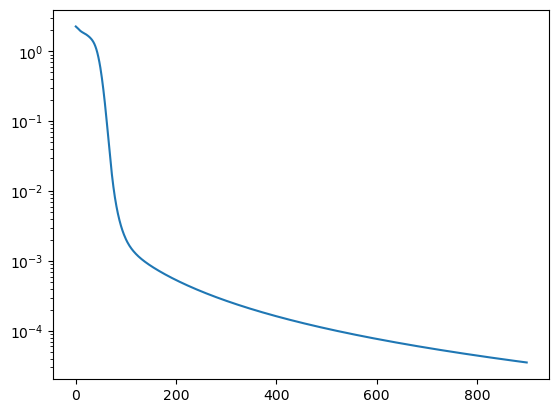

In [29]:
plt.semilogy(test_losses)
# plt.plot(train_losses)

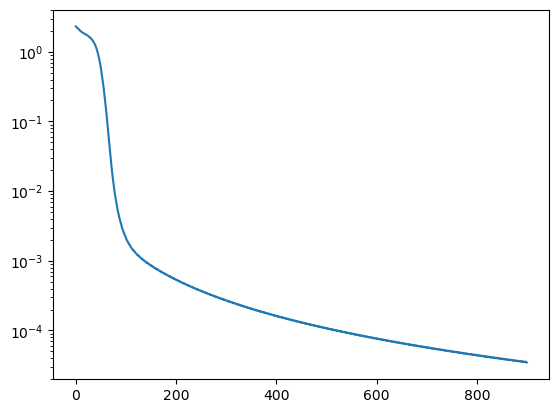

In [30]:

plt.semilogy(train_losses)

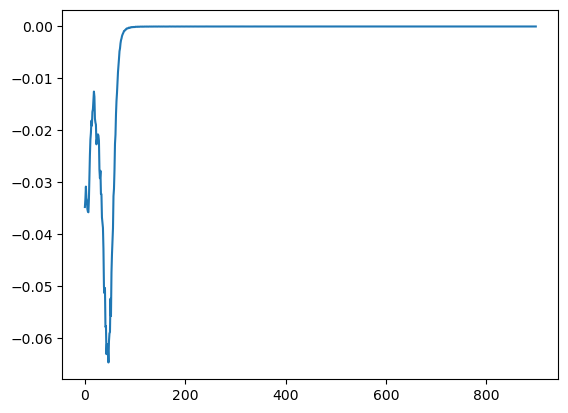

In [31]:
plt.plot(t.tensor(test_losses)-t.tensor(train_losses))
